cara extract file

In [33]:
!apt install unzip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [34]:
!unzip -q "/content/data.zip"

machine learning

In [163]:
import os
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models
from IPython import display

In [164]:
# Set the seed value for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Path to the dataset
DATASET_PATH = '/content/data'

data_dir = pathlib.Path(DATASET_PATH)
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['firetruck' 'ambulance' 'traffic']


In [165]:
# Load dataset
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1)
    return tf.squeeze(audio, axis=-1)

def get_waveform_and_label(file_path):
    label = tf.strings.split(file_path, os.path.sep)[-2]
    label = tf.argmax(label == commands)  # Convert label to integer
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

def get_dataset(data_dir):
    files = tf.data.Dataset.list_files(str(data_dir/'*/*'))
    output_ds = files.map(get_waveform_and_label, num_parallel_calls=tf.data.AUTOTUNE)
    return output_ds

In [166]:
# Split dataset into training, validation, and test sets
full_ds = get_dataset(data_dir)
full_ds = full_ds.shuffle(buffer_size=10000, seed=seed, reshuffle_each_iteration=False)
full_ds_size = len(list(full_ds))

train_size = int(0.8 * full_ds_size)
val_size = int(0.1 * full_ds_size)
test_size = full_ds_size - train_size - val_size

train_ds = full_ds.take(train_size)
val_ds = full_ds.skip(train_size).take(val_size)
test_ds = full_ds.skip(train_size + val_size)

print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")

Train size: 48, Validation size: 6, Test size: 6


In [167]:
# Preprocess dataset
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.image.resize(spectrogram[..., tf.newaxis], [1032, 129])  # Resize to expected shape
    return spectrogram

def make_spec_ds(ds):
    return ds.map(lambda audio, label: (get_spectrogram(audio), label), num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [168]:
# Add a dimension to the input spectrogram
def add_batch_dimension(spectrogram, label):
    spectrogram = tf.expand_dims(spectrogram, -1)  # Add channel dimension
    return spectrogram, label

train_spectrogram_ds = train_spectrogram_ds.map(add_batch_dimension)
val_spectrogram_ds = val_spectrogram_ds.map(add_batch_dimension)
test_spectrogram_ds = test_spectrogram_ds.map(add_batch_dimension)

In [169]:
# Cache, shuffle, and prefetch the datasets
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [170]:
# Build the model
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    input_shape = example_spectrograms.shape[1:]

num_labels = len(commands)

model = models.Sequential([
    layers.Input(shape=(input_shape[0], input_shape[1], 1)),  # Add channel dimension
    layers.Resizing(32, 32),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_14 (Resizing)      (None, 32, 32, 1)         0         
                                                                 
 conv2d_28 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_29 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_28 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 flatten_14 (Flatten)        (None, 12544)             0         
                                                     

In [171]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [172]:
# Periksa jumlah elemen dalam dataset
print(f"Number of elements in train dataset: {len(list(train_spectrogram_ds))}")
print(f"Number of elements in validation dataset: {len(list(val_spectrogram_ds))}")
print(f"Number of elements in test dataset: {len(list(test_spectrogram_ds))}")

Number of elements in train dataset: 2
Number of elements in validation dataset: 1
Number of elements in test dataset: 1


In [173]:
# Path to the dataset
DATASET_PATH = '/content/data'
data_dir = pathlib.Path(DATASET_PATH)
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['firetruck' 'ambulance' 'traffic']


In [174]:
# Load dataset
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1)
    return tf.squeeze(audio, axis=-1)

def get_waveform_and_label(file_path):
    label = tf.strings.split(file_path, os.path.sep)[-2]
    label = tf.argmax(label == commands)  # Convert label to integer
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

def get_dataset(data_dir):
    files = tf.data.Dataset.list_files(str(data_dir/'*/*'))
    output_ds = files.map(get_waveform_and_label, num_parallel_calls=tf.data.AUTOTUNE)
    return output_ds

# Preprocess dataset
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.image.resize(spectrogram[..., tf.newaxis], [1032, 129])  # Resize to expected shape
    return spectrogram

def make_spec_ds(ds):
    return ds.map(lambda audio, label: (get_spectrogram(audio), label), num_parallel_calls=tf.data.AUTOTUNE)

# Add a dimension to the input spectrogram
def add_batch_dimension(spectrogram, label):
    spectrogram = tf.expand_dims(spectrogram, -1)  # Add channel dimension
    return spectrogram, label

# Load and preprocess datasets
full_ds = get_dataset(data_dir)
full_ds = full_ds.shuffle(buffer_size=10000, seed=42, reshuffle_each_iteration=False)
full_ds_size = len(list(full_ds))

train_size = int(0.8 * full_ds_size)
val_size = int(0.1 * full_ds_size)
test_size = full_ds_size - train_size - val_size

train_ds = full_ds.take(train_size)
val_ds = full_ds.skip(train_size).take(val_size)
test_ds = full_ds.skip(train_size + val_size)

train_spectrogram_ds = make_spec_ds(train_ds).map(add_batch_dimension).cache().shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = make_spec_ds(val_ds).map(add_batch_dimension).cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = make_spec_ds(test_ds).map(add_batch_dimension).cache().batch(32).prefetch(tf.data.AUTOTUNE)

# Periksa jumlah elemen dalam dataset
print(f"Number of elements in train dataset: {len(list(train_spectrogram_ds))}")
print(f"Number of elements in validation dataset: {len(list(val_spectrogram_ds))}")
print(f"Number of elements in test dataset: {len(list(test_spectrogram_ds))}")

Number of elements in train dataset: 2
Number of elements in validation dataset: 1
Number of elements in test dataset: 1


In [175]:
# Load and preprocess datasets
full_ds = get_dataset(data_dir)
full_ds = full_ds.shuffle(buffer_size=10000, seed=42, reshuffle_each_iteration=False)
full_ds_size = len(list(full_ds))

# Pastikan dataset memiliki cukup data
if full_ds_size < 10:
    raise ValueError("Dataset terlalu kecil. Tambahkan lebih banyak data.")

train_size = int(0.8 * full_ds_size)
val_size = int(0.1 * full_ds_size)
test_size = full_ds_size - train_size - val_size

train_ds = full_ds.take(train_size)
val_ds = full_ds.skip(train_size).take(val_size)
test_ds = full_ds.skip(train_size + val_size)

train_spectrogram_ds = make_spec_ds(train_ds).map(add_batch_dimension).cache().shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = make_spec_ds(val_ds).map(add_batch_dimension).cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = make_spec_ds(test_ds).map(add_batch_dimension).cache().batch(32).prefetch(tf.data.AUTOTUNE)

# Periksa jumlah elemen dalam dataset
print(f"Number of elements in train dataset: {len(list(train_spectrogram_ds))}")
print(f"Number of elements in validation dataset: {len(list(val_spectrogram_ds))}")
print(f"Number of elements in test dataset: {len(list(test_spectrogram_ds))}")

Number of elements in train dataset: 2
Number of elements in validation dataset: 1
Number of elements in test dataset: 1


In [177]:
# Train the model
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
2/2 [==============================] - 0s 134ms/step - loss: 0.1011 - accuracy: 0.9792 - val_loss: 0.0309 - val_accuracy: 1.0000
Epoch 2/10
2/2 [==============================] - 0s 145ms/step - loss: 0.1168 - accuracy: 0.9583 - val_loss: 0.0301 - val_accuracy: 1.0000
Epoch 3/10
2/2 [==============================] - 0s 86ms/step - loss: 0.0300 - accuracy: 1.0000 - val_loss: 0.0282 - val_accuracy: 1.0000
Epoch 4/10
2/2 [==============================] - 0s 88ms/step - loss: 0.0371 - accuracy: 1.0000 - val_loss: 0.0139 - val_accuracy: 1.0000
Epoch 5/10
2/2 [==============================] - 0s 99ms/step - loss: 0.0288 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 6/10
2/2 [==============================] - 0s 75ms/step - loss: 0.0246 - accuracy: 1.0000 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 7/10
2/2 [==============================] - 0s 79ms/step - loss: 0.0233 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 8/10
2/2 [=========

Text(0, 0.5, 'Accuracy [%]')

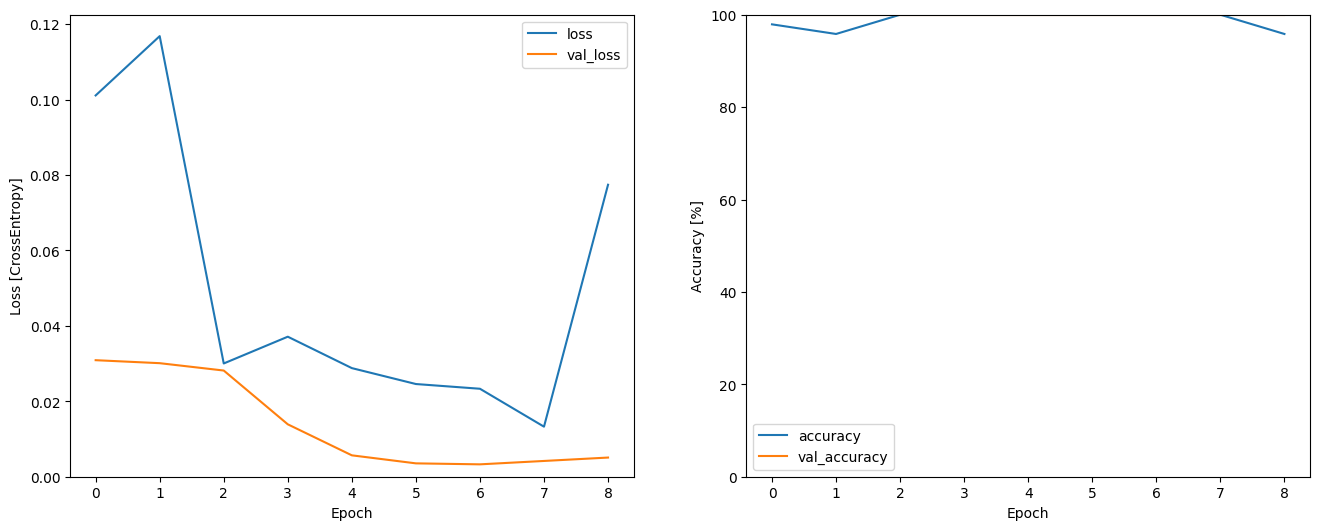

In [178]:
# Evaluate the model
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, 100 * np.array(metrics['accuracy']), 100 * np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [179]:
# Evaluate on test set
model.evaluate(test_spectrogram_ds, return_dict=True)

1/1 [==============================] - 0s 38ms/step - loss: 0.0015 - accuracy: 1.0000


{'loss': 0.0014717624289914966, 'accuracy': 1.0}

In [180]:
# Predict on new audio
def predict(model, file_path):
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    spectrogram = get_spectrogram(waveform)
    spectrogram = tf.expand_dims(spectrogram, -1)  # Add channel dimension
    spectrogram = spectrogram[tf.newaxis, ...]  # Add batch dimension
    prediction = model(spectrogram)
    predicted_label = tf.argmax(prediction, axis=1)
    return commands[predicted_label.numpy()[0]]

# Mengetest dari directory file yang ada

In [183]:
# Example prediction
file_path = '/content/test/test3.wav'  # Replace with your audio file path
predicted_label = predict(model, file_path)
print(f'Predicted label: {predicted_label}')

Predicted label: traffic


# Mengetest dengan upload file

In [190]:
from google.colab import files
import tensorflow as tf
import numpy as np

# Fungsi untuk mengunggah file
def upload_audio():
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f'User uploaded file "{filename}" with length {len(uploaded[filename])} bytes')
    return list(uploaded.keys())[0]

# Fungsi untuk memproses dan memprediksi audio
def predict_uploaded_audio(model, commands, filename):
    # Proses audio yang diunggah
    audio_binary = tf.io.read_file(filename)
    waveform = decode_audio(audio_binary)
    spectrogram = get_spectrogram(waveform)
    spectrogram = tf.expand_dims(spectrogram, -1)  # Tambahkan dimensi channel
    spectrogram = spectrogram[tf.newaxis, ...]  # Tambahkan dimensi batch

    # Prediksi menggunakan model
    prediction = model(spectrogram)
    predicted_label = tf.argmax(prediction, axis=1)
    return commands[predicted_label.numpy()[0]]

# Contoh penggunaan
commands = np.array(['firetruck', 'ambulance', 'traffic'])  # Ganti dengan label yang sesuai

# Unggah file audio
filename = upload_audio()

# Prediksi label dari file audio yang diunggah
predicted_label = predict_uploaded_audio(model, commands, filename)
print(f'Predicted label: {predicted_label}')

Saving audio1.wav to audio1.wav
User uploaded file "audio1.wav" with length 1564750 bytes
Predicted label: firetruck


# Mengetest secara live

In [202]:
!pip install pydub
!pip install ffmpeg-python

In [203]:
from IPython.display import Javascript, display
from google.colab import output
from base64 import b64decode
from io import BytesIO
from pydub import AudioSegment
import ffmpeg

In [204]:
def fix_riff_header(binary):
    process = (ffmpeg
        .input('pipe:0')
        .output('pipe:1', format='wav')
        .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
    )
    output, _ = process.communicate(input=binary)
    return output

def record(sec=3):
    display(Javascript(RECORD_JS))
    print("Recording...")
    s = output.eval_js('record(%d)' % (sec * 1000))
    b = b64decode(s.split(',')[1])
    b = fix_riff_header(b)
    with open('audio.wav', 'wb') as f:
        f.write(b)
    audio = AudioSegment.from_wav('audio.wav')
    return audio

# Rekam audio selama 5 detik
audio = record(5)
audio.export("recorded_audio.wav", format="wav")

# Putar kembali audio yang direkam
import IPython.display as ipd
ipd.Audio("recorded_audio.wav")

<IPython.core.display.Javascript object>

Recording...


In [205]:
# prediction
file_path = '/content/recorded_audio.wav'  # Replace with your audio file path
predicted_label = predict(model, file_path)
print(f'Predicted label: {predicted_label}')

Predicted label: ambulance
